In [1]:
using QuantumBayesian
using PyPlot

# Single Qubit Evolution Tests

**Justin Dressel**, 12/6/2016 <br />
*Institute for Quantum Studies, Chapman University*

Benchmark various integration algorithms for a single qubit damped Rabi oscillation, for comparison with the DifferentialEquations package tested in a separate notebook.

## Basic Definitions

### Qubit Hilbert space

In [2]:
q = qubit()

QuantumBayesian.QFactor: Qubit
Dims  : 2
Ops   : "d", "y", "x", "u", "z", "i"


### Global Constants

In [3]:
Ω  = 2*π;        # Rabi frequency
τ = 3.0;         # Measurement collapse timescale
Γ = 1/(2*τ);     # Measurement dephasing rate (quantum-limited efficiency)
T = (0.0, 6*τ);  # Time duration of simulation;

dt = 1e-2;       # Simulation timestep (coarse to show method precision);

### Common Trajectory and Plotting Code

In [4]:
# Initial conditions (matrix and superket)
init = ground(q)
sinit = superket(init)

# Bloch expectation values (matrix and superket)
fs  = collect(ρ -> real(expect(ρ, q(l))) for l in ["x","y","z"])
sfs = collect(ρ -> real(expect(unsuperket(ρ),q(l))) for l in ["x","y","z"])

# Trajectory and plotting function
function solve(inc, init, dt, T, fs, plot_title; readout=false, n=1)
    figure(1)
    if n==1
        out = trajectory(inc, init, (0.0, 0.1), fs..., dt=dt, points=10, verbose=false) #JIT throw-away
        @time out = trajectory(inc, init, T, fs..., dt=dt)
        plot(out[1].t,out[1],label=L"$x$",color="r")
        hold(true)
        plot(out[2].t,out[2],label=L"$y$",color="g")
        plot(out[3].t,out[3],label=L"$z$",color="b")
        hold(false)
    else
        out = ensemble(1, inc, init, (0.0, 0.1), fs..., dt=dt, points=10, verbose=false) #JIT throw-away
        @time out = ensemble(n, inc, init, T, fs..., dt=dt)
        m1 = mean(out[1]); m2 = mean(out[2]); m3 = mean(out[3]);
        s1 = std(out[1]); s2 = std(out[2]); s3 = std(out[3]);
        plot(out[1].t,m1,label=L"$x$",color="r")
        hold(true)
        plot(out[2].t,m2,label=L"$y$",color="g")
        plot(out[3].t,m3,label=L"$z$",color="b")
        fill_between(out[1].t, m1-s1, m1+s1, color="r", alpha=0.2, antialiased=true)
        fill_between(out[2].t, m2-s2, m2+s2, color="g", alpha=0.2, antialiased=true)
        fill_between(out[3].t, m3-s3, m3+s3, color="b", alpha=0.2, antialiased=true)
        hold(false)
    end
    ax = gca()
    ax[:set_ylim]([-1.1,1.1])
    xlabel(L"$t (2\pi/\Omega)$")
    ylabel("Bloch coordinates")
    title(plot_title)
    legend()
    hold(false)
    show()
    if readout
        figure(2)
        if n==1
            plot(out[4].t,out[4],label=L"$r_z$",color="k")
        else
            m4 = mean(out[4]); s4 = std(out[4]); 
            plot(out[4].t,m4,label=L"$r_z$",color="k")
            hold(true)
            fill_between(out[4].t, m4-s4, m4+s4, color="k", alpha=0.2, antialiased=true)
            hold(false)
        end
        xlabel(L"$t (2\pi/\Omega)$")
        ylabel("Stochastic readout")
        title(plot_title*" Readout")
        legend()
        show()
    end
end;

## Time-independent Rabi Hamiltonian

In [5]:
# Hamiltonian
H = (Ω/2)*q("y");
# Measurement dephasing
DM = sqrt(Γ/2)*q("z");
# Stochastic monitoring (unit efficiency)
SM = [(q("z"), τ, 1.0)];

### Coherent (Hamiltonian) Evolution

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.016430623 s, Steps per second: 109490.67482103388


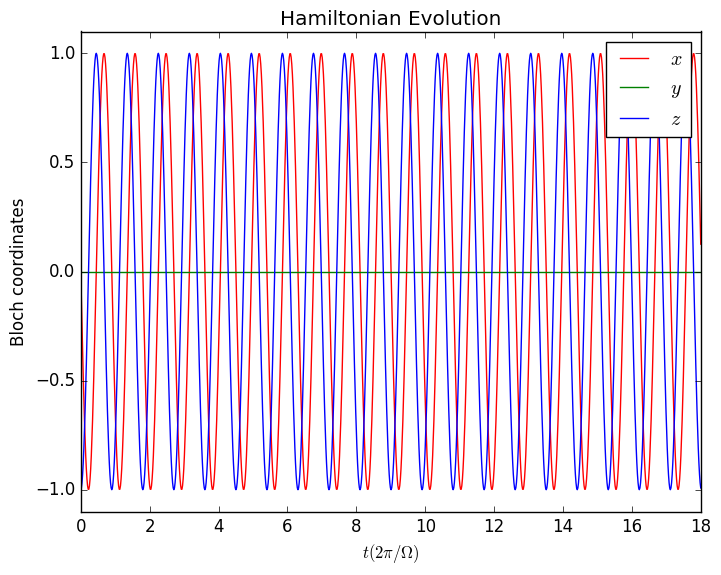

In [6]:
solve(ham(dt, H), init, dt, T, fs, "Hamiltonian Evolution")

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.055529034 s, Steps per second: 32397.466161575943


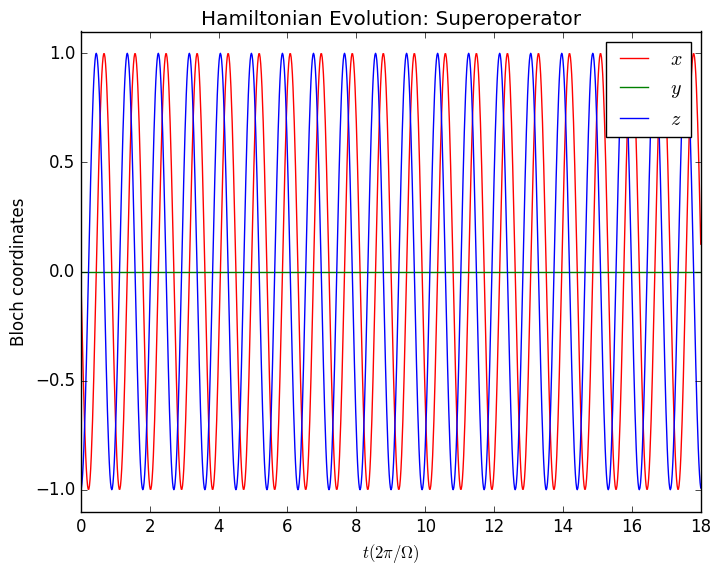

In [7]:
solve(sham(dt, H), sinit, dt, T, sfs, "Hamiltonian Evolution: Superoperator")

### Dissipative (Lindblad) Evolution

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.108911859 s, Steps per second: 16517.94411111833


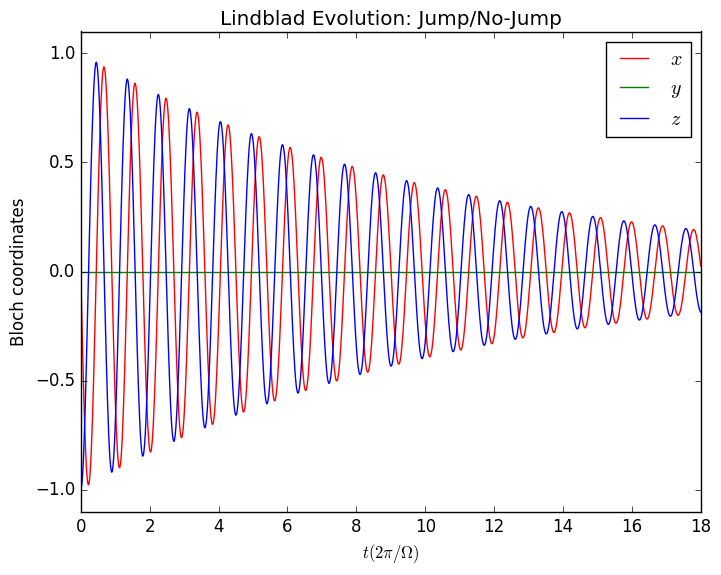

In [8]:
solve(lind(dt, H, clist=[DM]), init, dt, T, fs, "Lindblad Evolution: Jump/No-Jump")

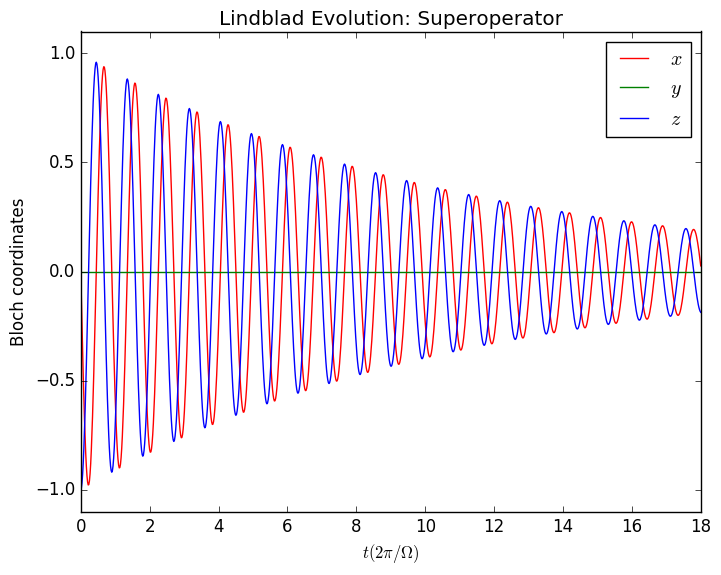

  0.057597 seconds (167.78 k allocations: 9.829 MB, 8.96% gc time)


INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.057133652 s, Steps per second: 31487.57233302713


In [9]:
solve(slind(dt, H, clist=[DM]), sinit, dt, T, sfs, "Lindblad Evolution: Superoperator")

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 1.001519804 s, Steps per second: 1796.2700216360374


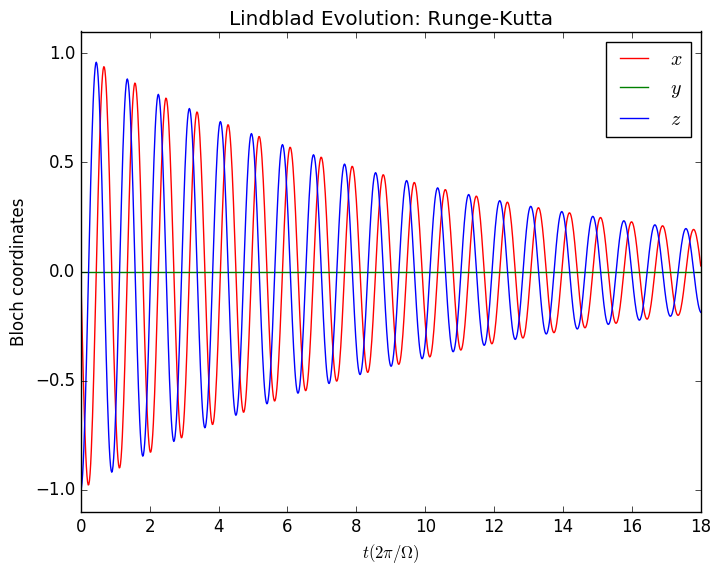

In [10]:
solve(lind_rk4(dt, H, clist=[DM]), init, dt, T, fs, "Lindblad Evolution: Runge-Kutta")

### Stochastic (Monitored) Evolution

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.071104428 s, Steps per second: 25300.815302248124


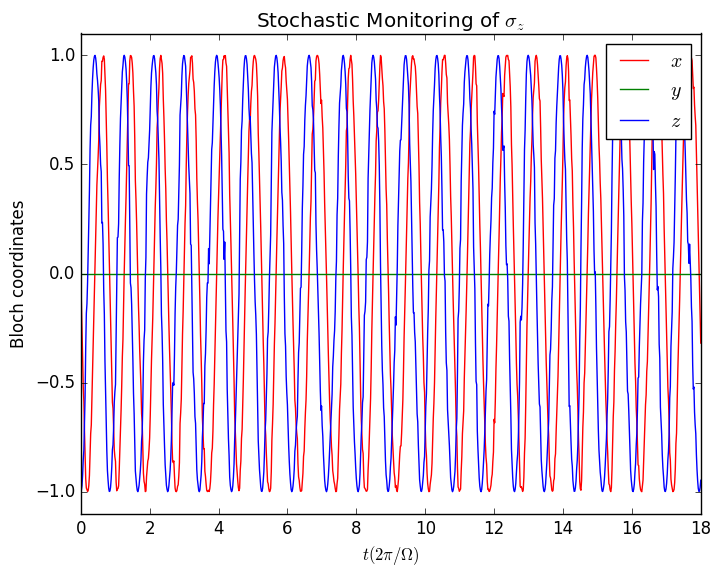

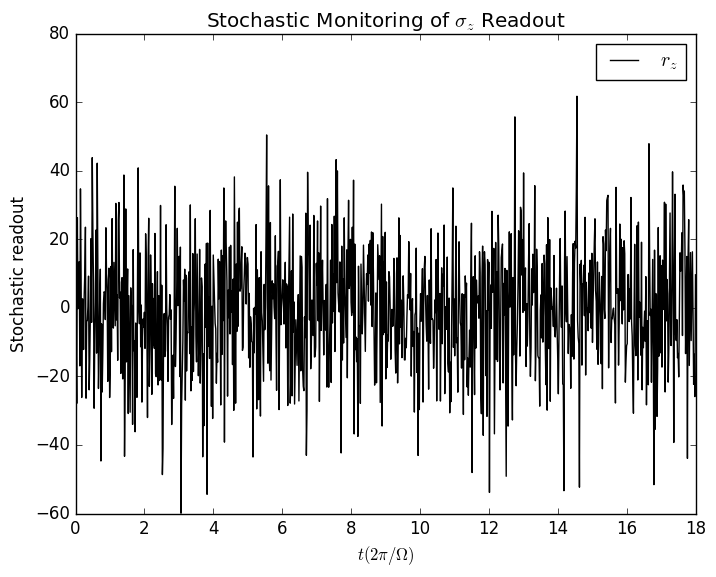

In [11]:
solve(meas(dt, H, mclist=SM), init, dt, T, fs, L"Stochastic Monitoring of $\sigma_z$", readout=true)

(Note: no parallelization performed here to benchmark serial execution of an ensemble simulation. Plotted is the mean with shaded standard deviation behind.)

INFO: Trajectories: 2500, steps each: 1799, points each: 1000, values each = 3
INFO: Readouts: values each = 1


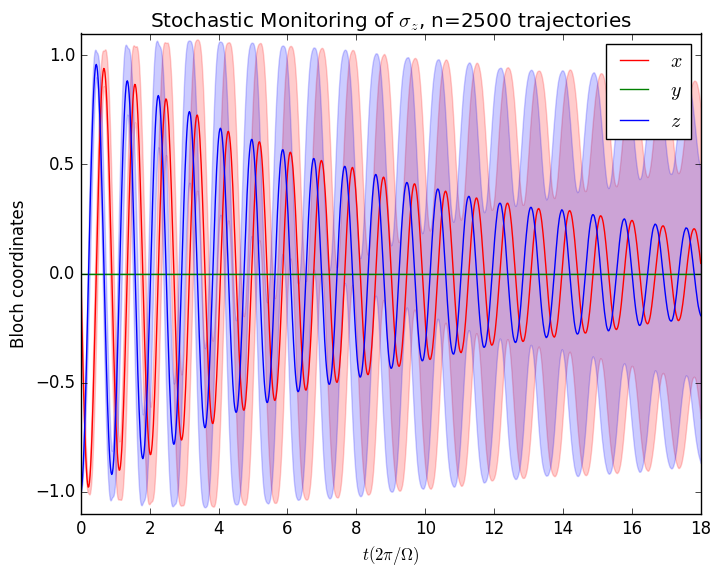

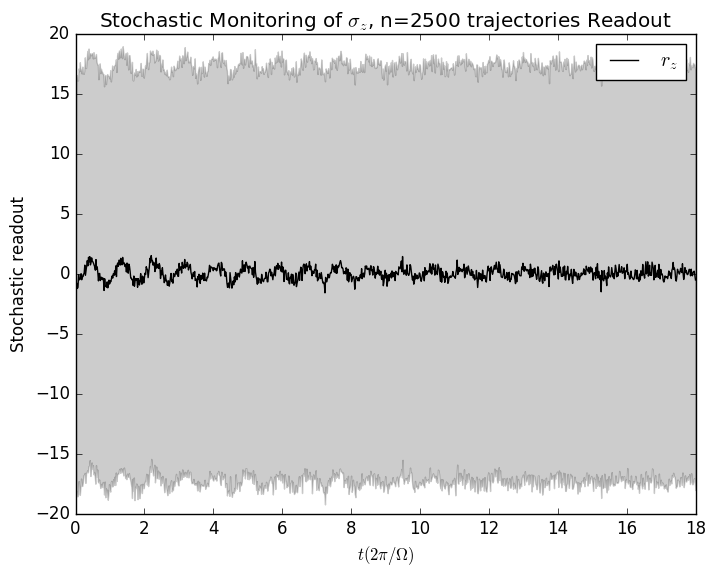

In [12]:
solve(meas(dt, H, mclist=SM), init, dt, T, fs, L"Stochastic Monitoring of $\sigma_z$, n=2500 trajectories", readout=true, n=2500)

## Time-dependent Rabi Pulse

In [13]:
# Hamiltonian
f(t::Float64) = 2*exp(-(t-3*τ)^2/2)/sqrt(2π)
h(t::Float64) = f(t)*(Ω/2)*q("y");

### Coherent (Hamiltonian) Evolution

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.0375139 s, Steps per second: 47955.55780657303


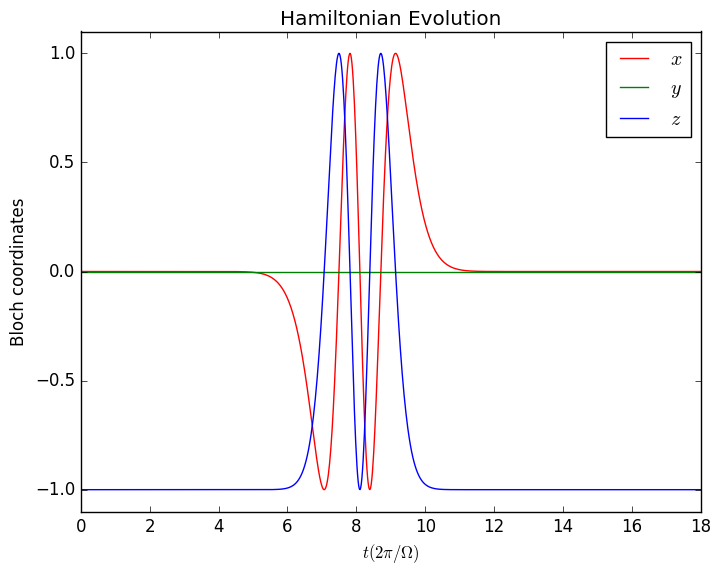

  0.037966 seconds (267.42 k allocations: 18.799 MB, 10.20% gc time)


In [14]:
solve(ham(dt, h), init, dt, T, fs, "Hamiltonian Evolution")

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.141525743 s, Steps per second: 12711.46832982887


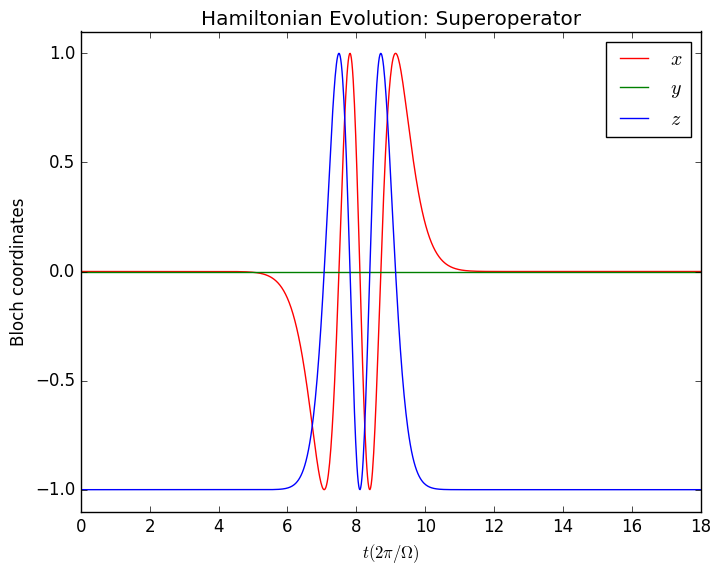

In [15]:
solve(sham(dt, h), sinit, dt, T, sfs, "Hamiltonian Evolution: Superoperator")

### Dissipative (Lindblad) Evolution

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.140881478 s, Steps per second: 12769.599137794394


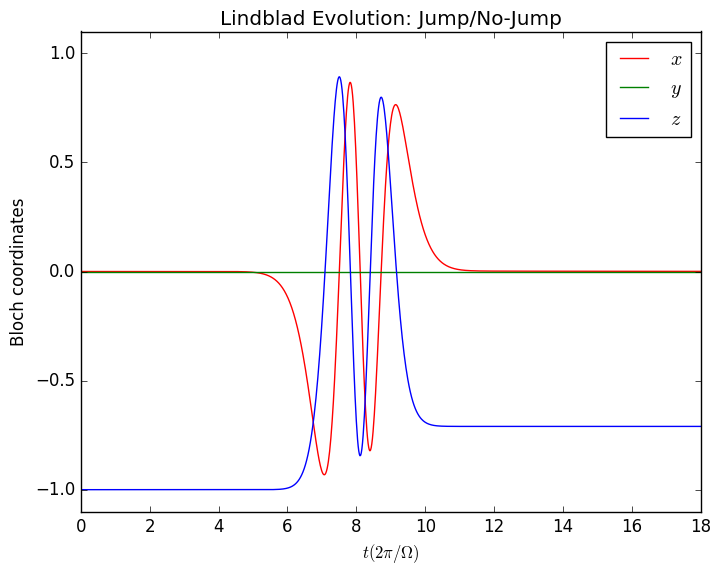

In [16]:
solve(lind(dt, h, clist=[DM]), init, dt, T, fs, "Lindblad Evolution: Jump/No-Jump")

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.31987172 s, Steps per second: 5624.129572942553


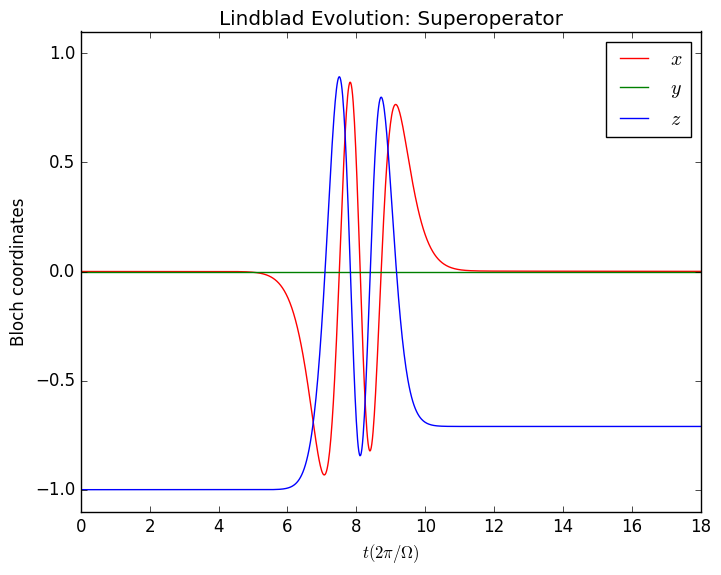

In [17]:
solve(slind(dt, h, clist=[DM]), sinit, dt, T, sfs, "Lindblad Evolution: Superoperator")

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 1.014108128 s, Steps per second: 1773.9725679429719


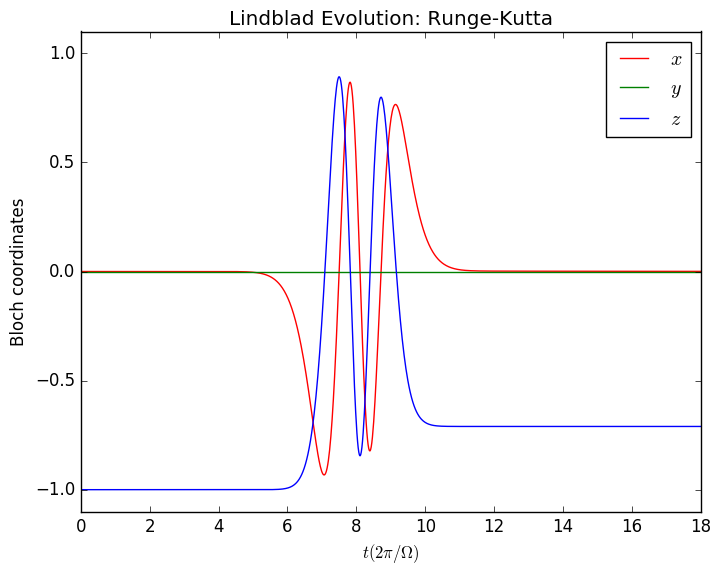

In [18]:
solve(lind_rk4(dt, h, clist=[DM]), init, dt, T, fs, "Lindblad Evolution: Runge-Kutta")

### Stochastic (Monitored) Evolution

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Readout: values = 1


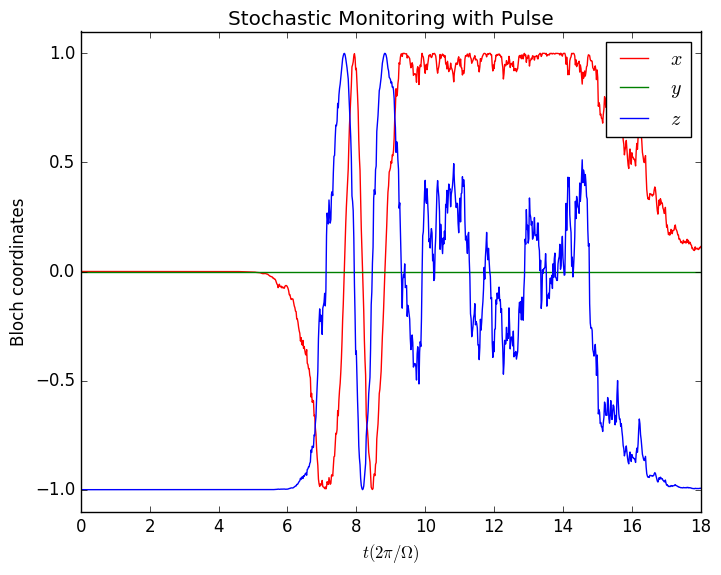

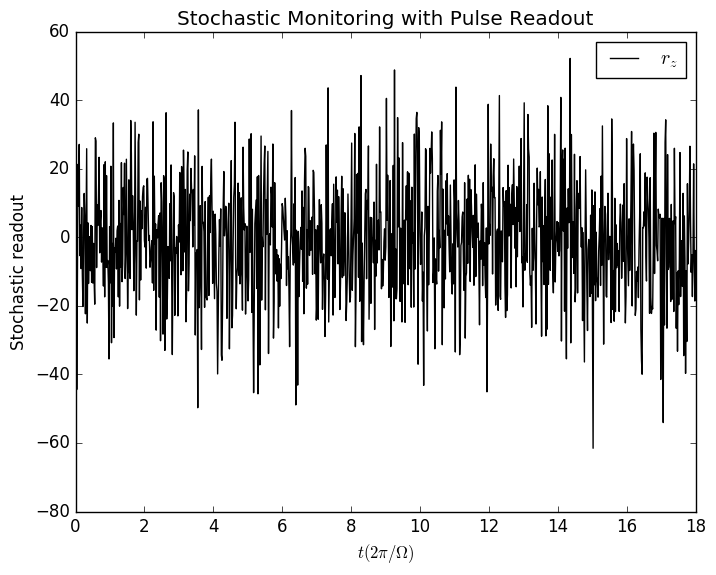

  0.110398 seconds (551.38 k allocations: 39.477 MB, 7.48% gc time)


INFO: Time elapsed: 0.109057625 s, Steps per second: 16495.866290871454


In [19]:
solve(meas(dt, h, mclist=SM), init, dt, T, fs, "Stochastic Monitoring with Pulse", readout=true)

INFO: Trajectories: 2500, steps each: 1799, points each: 1000, values each = 3
INFO: Readouts: values each = 1


270.

INFO: Time elapsed: 270.840864285 s, Steps: 2500000, Steps per second: 9230.512561683838


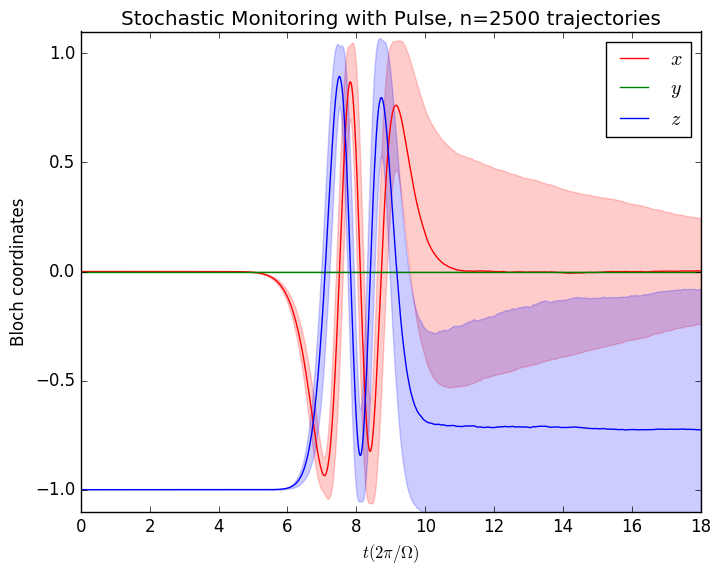

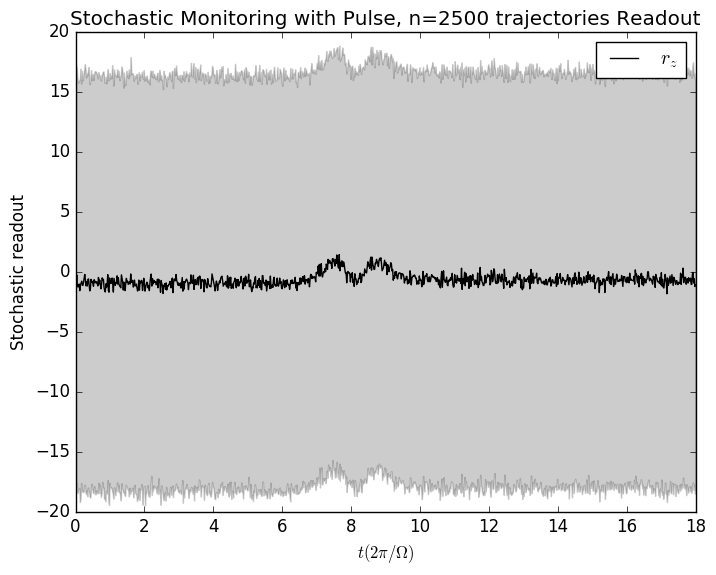

In [20]:
solve(meas(dt, h, mclist=SM), init, dt, T, fs, "Stochastic Monitoring with Pulse, n=2500 trajectories", readout=true, n=2500)

## Version Information

In [21]:
versioninfo()

Julia Version 0.5.0
Commit 3c9d753 (2016-09-19 18:14 UTC)
Platform Info:
  System: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-4790 CPU @ 3.60GHz
  WORD_SIZE: 64
  BLAS: libopenblas (DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas
  LIBM: libm
  LLVM: libLLVM-3.7.1 (ORCJIT, haswell)


In [22]:
Pkg.installed("PyPlot")

v"2.2.4"

In [23]:
Pkg.installed("Interpolations")

v"0.3.6"

In [24]:
Pkg.installed("QuantumBayesian")

v"0.1.0+"